### DONT FORGET TO SWITCH KERNEL TO GPU!!!

In [1]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 2.0.0
Default GPU Device: /device:GPU:0


In [2]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping

from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

keras.__version__

Using TensorFlow backend.


'2.3.1'

In [3]:
# more data for handwriting recognition?
# Let's use Raschka's implementation for using the mnist dataset:
# https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb
import os
import struct
import numpy as np
# from sklearn.preprocessing import RobustScaler
 
def load_mnist(path, kind='fashion_train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels

X_train, y_train = load_mnist('data/', kind='fashion_train')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('data/', kind='fashion_t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

X_train = X_train/255.0 - 0.5
X_test = X_test/255.0 - 0.5

NUM_CLASSES = 10

y_train.shape

Rows: 60000, columns: 784
Rows: 10000, columns: 784


(60000,)

In [4]:
def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(acc_mlp))

In [4]:
%%time

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

# make a keras MLP
mlp = Sequential()
mlp.add( Dense(input_dim=X_train.shape[1], units=100, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train, 
        y_train_ohe, 
        batch_size=32, 
        epochs=15, 
        shuffle=True, 
        verbose=1,
        callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
       )

Epoch 1/15
60000/60000 [==============================] - 67s 1ms/step - loss: 0.5095 - accuracy: 0.8157
Epoch 2/15
60000/60000 [==============================] - 69s 1ms/step - loss: 0.3864 - accuracy: 0.8597
Epoch 3/15
60000/60000 [==============================] - 67s 1ms/step - loss: 0.3542 - accuracy: 0.8720
Epoch 4/15
60000/60000 [==============================] - 67s 1ms/step - loss: 0.3385 - accuracy: 0.8787
Epoch 5/15
60000/60000 [==============================] - 68s 1ms/step - loss: 0.3314 - accuracy: 0.8824
Epoch 6/15
60000/60000 [==============================] - 67s 1ms/step - loss: 0.3280 - accuracy: 0.8838
Epoch 7/15
60000/60000 [==============================] - 65s 1ms/step - loss: 0.3292 - accuracy: 0.8860
Epoch 8/15
60000/60000 [==============================] - 68s 1ms/step - loss: 0.3280 - accuracy: 0.8863
Epoch 9/15
60000/60000 [==============================] - 66s 1ms/step - loss: 0.3253 - accuracy: 0.8866
Epoch 10/15
54656/60000 [==========================>...

KeyboardInterrupt: 

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 7s 114us/step - loss: 0.0239 - accuracy: 0.8293 - val_loss: 0.0178 - val_accuracy: 0.8777
Epoch 2/15
60000/60000 [==============================] - 7s 111us/step - loss: 0.0157 - accuracy: 0.8921 - val_loss: 0.0160 - val_accuracy: 0.8889
Epoch 3/15
60000/60000 [==============================] - 7s 111us/step - loss: 0.0136 - accuracy: 0.9072 - val_loss: 0.0142 - val_accuracy: 0.9009
Epoch 4/15
60000/60000 [==============================] - 7s 110us/step - loss: 0.0122 - accuracy: 0.9171 - val_loss: 0.0143 - val_accuracy: 0.9044
Epoch 5/15
60000/60000 [==============================] - 7s 111us/step - loss: 0.0113 - accuracy: 0.9240 - val_loss: 0.0137 - val_accuracy: 0.9067
Epoch 6/15
60000/60000 [==============================] - 7s 111us/step - loss: 0.0105 - accuracy: 0.9296 - val_loss: 0.0135 - val_accuracy: 0.9091
Epoch 7/15
60000/60000 [==============================] - 7s 1

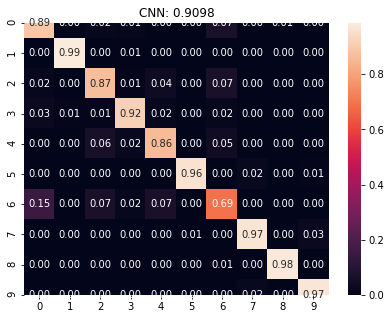

In [6]:
%%time

img_wh = 28 # width and height of Fashion MNIST images

y_train_ohe = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, NUM_CLASSES)

# changes: 
#    1. Baseline: 2 conv layers and two output layers
cnn1 = Sequential()
cnn1.add( Reshape((1,img_wh, img_wh), input_shape=(1,img_wh**2)) )

num_filt_layers = [24, 24]
for num_filters in num_filt_layers:
    cnn1.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same',data_format="channels_first") )
    cnn1.add( Activation('relu'))
    cnn1.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first") )
    

# add one layer on flattened output
cnn1.add( Flatten() )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(100, activation='relu') )
cnn1.add( Dense(NUM_CLASSES, activation='softmax') )

# Let's train the model 
cnn1.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn1.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
         batch_size=32, 
         epochs=15, 
         shuffle=True, 
         verbose=1,
         validation_data=(np.expand_dims(X_test, axis=1),y_test_ohe),
         callbacks=[EarlyStopping(monitor='val_loss', patience=2)]
        )

compare_mlp_cnn(cnn1,None,X_test,y_test)